In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

## Lecturas de los datos

In [2]:
data_path = '/workspace/data/data_recom/'
movies_filename = 'movie.csv'
ratings_filename = 'rating.csv'

In [3]:
df_movies = pd.read_csv(
    os.path.join(data_path, movies_filename),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/data/data_recom/movie.csv'

In [5]:
df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [6]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [7]:
df_movies.shape

(27278, 2)

In [8]:
df_ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [9]:
df_ratings.shape

(20000263, 3)

In [10]:
df_ratings=df_ratings[:2000000]

In [11]:
df_ratings.shape

(2000000, 3)

## Exploración de los datos

In [12]:
df_movie_features = df_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [15]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print(f'Numero de Usuarios {num_users} Numero de items {num_items}')

Numero de Usuarios 13567 Numero de items 16715


<AxesSubplot:xlabel='rating'>

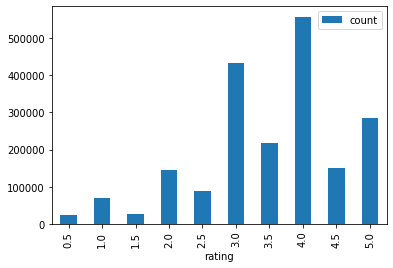

In [16]:
# We only have movies with at least 0.5 rating in df_ratings
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp.plot.bar()

<AxesSubplot:>

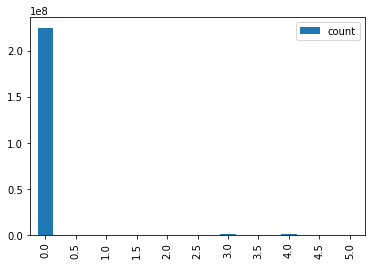

In [20]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt.plot.bar()

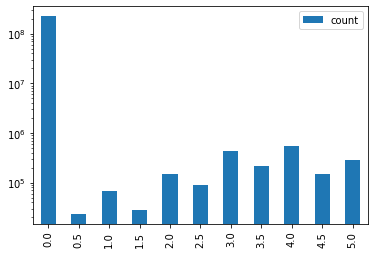

In [22]:
fig, ax = plt.subplots()
df_ratings_cnt.plot.bar(ax=ax)
ax.set_yscale('log')

In [23]:
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,4883
2,2209
3,1256
4,272
5,1227


In [54]:
df_movies_cnt = df_movies_cnt.sort_values(by='count', ascending=False)

In [52]:
def mapper(x):
    pelicula = df_movies[df_movies.movieId==x]
    return pelicula.title.iloc[0] 

In [55]:
df_movies_cnt.loc[:, 'title'] = df_movies_cnt.index.map(mapper)

In [56]:
df_movies_cnt.head()

,count,title
movieId,,
296,6688,Pulp Fiction (1994)
356,6599,Forrest Gump (1994)
593,6221,"Silence of the Lambs, The (1991)"
318,6199,"Shawshank Redemption, The (1994)"
480,5943,Jurassic Park (1993)


## Content based 

In [57]:
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)

shape of original ratings data:  (2000000, 3)


In [58]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()
# filter data to come to an approximation of user likings.
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
#map movie titles to images
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}

shape of original ratings data:  (2000000, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (1712154, 3)


Modelo basado en distancias:

In [59]:
# Generamos una matriz sparse
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)
# Definimos el modelo basdo en la distancia cosine
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [63]:
from fuzzywuzzy import fuzz
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True
    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]


def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie
    Parameters
    ----------
    model_knn: sklearn model, knn model
    data: movie-user matrix
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    n_recommendations: int, top n recommendations
    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends =         sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [64]:
my_favorite = 'Iron Man'
my_favorite = 'Pulp Fiction'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10
)

You have input movie: Pulp Fiction
Found possible matches in our database: ['Pulp Fiction (1994)']

Recommendation system start to make inference
......

Recommendations for Pulp Fiction:
1: Twelve Monkeys (a.k.a. 12 Monkeys) (1995), with distance of 0.33927464485168457
2: Braveheart (1995), with distance of 0.3383672833442688
3: Jurassic Park (1993), with distance of 0.33565330505371094
4: Terminator 2: Judgment Day (1991), with distance of 0.33307188749313354
5: Fargo (1996), with distance of 0.3228304386138916
6: Forrest Gump (1994), with distance of 0.28859490156173706
7: Seven (a.k.a. Se7en) (1995), with distance of 0.2868938446044922
8: Usual Suspects, The (1995), with distance of 0.27472013235092163
9: Shawshank Redemption, The (1994), with distance of 0.27108168601989746
10: Silence of the Lambs, The (1991), with distance of 0.2395552396774292


## Matrix Factoriztion

In [3]:
df_movies = pd.read_csv(
    os.path.join(data_path, movies_filename),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [4]:
df_ratings=df_ratings[:2000000]
df_movie_features = df_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [5]:
df_movie_features

movieId,1,2,3,4,5,6,7,8,9,10,...,130073,130075,130219,130462,130490,130496,130512,130642,130644,130768
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13564,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13565,4.5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
R = df_movie_features.values
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [7]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)

In [8]:
sigma = np.diag(sigma)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [ ]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = df_movie_features.columns)
preds_df.head()

In [ ]:
def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',
               right_on = 'movieId').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations

In [ ]:
already_rated, predictions = recommend_movies(preds_df, 200, df_movies, df_ratings, 10)

In [ ]:
already_rated

In [ ]:
predictions